In [ ]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [ ]:
# İndirilecek dizin URL'si
base_url = 'https://svs.gsfc.nasa.gov/vis/a000000/a005200/a005276/frames/3840x2160_16x9_60p/nightlights_2023_globe/'

# İndirme klasörü
download_folder = 'nightlights_2023_globe_images'
os.makedirs(download_folder, exist_ok=True)

In [ ]:
# Sayfanın içeriğini al
response = requests.get(base_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Tüm bağlantıları bul
links = soup.find_all('a')

# Görüntü bağlantılarını filtrele ve indir
for link in links:
    href = link.get('href')
    if href and href.endswith('.exr'):
        image_url = urljoin(base_url, href)
        image_name = os.path.join(download_folder, href)
        print(f'İndiriliyor: {image_url}')
        img_data = requests.get(image_url).content
        with open(image_name, 'wb') as handler:
            handler.write(img_data)


In [ ]:
!pip install OpenEXR

In [1]:
import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt
import os


In [3]:
# EXR dosyasını okuyan ve RGB formatında döndüren fonksiyon
def load_exr_image(file_path):
    # Dosyayı aç
    exr_file = OpenEXR.InputFile(file_path)
    
    # EXR formatı HALF olduğundan dönüşüm tipi belirleniyor
    pixel_type = Imath.PixelType(Imath.PixelType.HALF)
    
    # Tüm RGB kanallarını oku ve float32'ye dönüştür
    data = [np.frombuffer(exr_file.channel(c, pixel_type), dtype=np.float16).astype(np.float32).reshape((2160, 3840)) for c in ['R', 'G', 'B']]
    rgb_image = np.stack(data, axis=-1)
    
    return rgb_image

In [5]:

# Görselleştirme fonksiyonu
def visualize_exr_images(folder_path, num_images=10):
    # Klasördeki tüm .exr dosyalarını al
    exr_files = [f for f in os.listdir(folder_path) if f.endswith('.exr')]
    
    # İlk `num_images` kadar dosyayı işle
    for file_name in exr_files[:num_images]:
        file_path = os.path.join(folder_path, file_name)
        
        # RGB görüntüyü yükle
        rgb_image = load_exr_image(file_path)
        
        # Görüntüyü normalize et
        normalized_image = rgb_image / np.max(rgb_image)
        
        # Görselleştir
        plt.figure(figsize=(10, 6))
        plt.imshow(normalized_image)
        plt.title(f"EXR Uydu Görüntüsü: {file_name}")
        plt.axis("off")
        plt.show()


In [7]:
# Veri hazırlığı fonksiyonu
def prepare_brightness_data(folder_path):
    # Klasördeki tüm .exr dosyalarını al
    exr_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.exr')])
    
    # Parlaklık verilerini saklamak için liste
    brightness_data = []

    for file_name in exr_files:
        file_path = os.path.join(folder_path, file_name)
        
        # RGB görüntüyü yükle
        rgb_image = load_exr_image(file_path)
        
        # Toplam parlaklık (örnek ölçüm olarak)
        total_brightness = np.sum(rgb_image)
        
        # Tarih ve parlaklık verisini kaydet
        brightness_data.append((file_name, total_brightness))
    
    return brightness_data

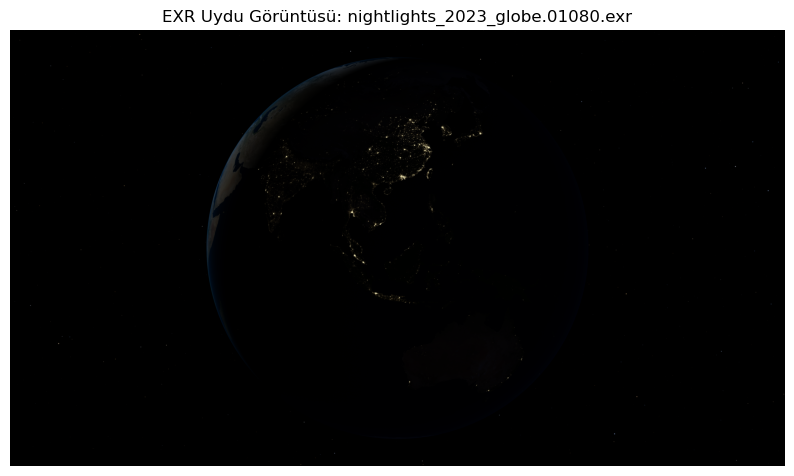

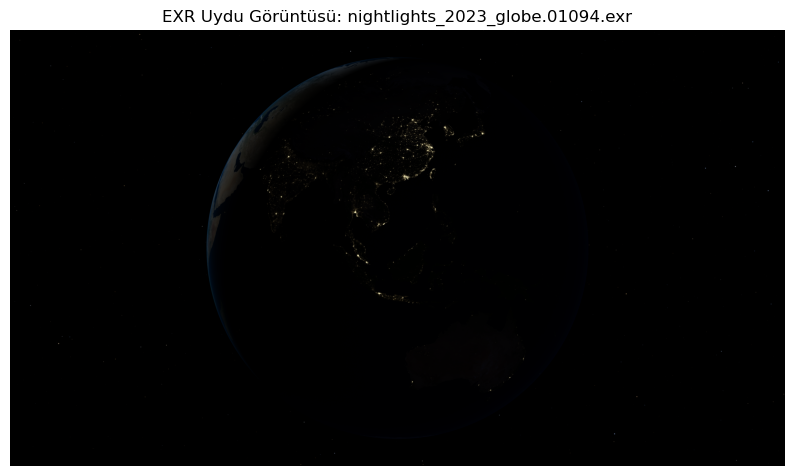

In [9]:
folder_path = "./nightlights_2023_globe_images/"
visualize_exr_images(folder_path, num_images=2)

In [10]:
brightness_data = prepare_brightness_data(folder_path)

In [11]:
brightness_data[:10]

[('nightlights_2023_globe.01000.exr', 81740.58),
 ('nightlights_2023_globe.01001.exr', 81767.49),
 ('nightlights_2023_globe.01002.exr', 81819.305),
 ('nightlights_2023_globe.01003.exr', 81868.13),
 ('nightlights_2023_globe.01004.exr', 81900.664),
 ('nightlights_2023_globe.01005.exr', 81985.56),
 ('nightlights_2023_globe.01006.exr', 82030.02),
 ('nightlights_2023_globe.01007.exr', 82080.43),
 ('nightlights_2023_globe.01008.exr', 82125.69),
 ('nightlights_2023_globe.01009.exr', 82133.59)]

In [13]:
import pandas as pd

# DataFrame'e dönüştür
df = pd.DataFrame(brightness_data, columns=["file_name", "brightness"])

# Dosya isminden sırayı çıkart
df['sequence'] = df['file_name'].str.extract(r'(\d{5})').astype(int)


In [14]:
from sklearn.preprocessing import MinMaxScaler

# Parlaklık değerlerini normalize et
scaler = MinMaxScaler()
df['normalized_brightness'] = scaler.fit_transform(df[['brightness']])

In [15]:
import numpy as np

# Giriş dizilerini oluştur
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)



In [16]:
# Test verisi olarak son 100 günü ayır
test_size = 100
sequence_length = 10
train_data = df['normalized_brightness'].values[:-test_size]
test_data = df['normalized_brightness'].values[-test_size:]

# LSTM girişlerini oluştur
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# LSTM girişlerini yeniden şekillendir
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Simple LSTM Modeli

In [18]:
import numpy as np
import tensorflow as tf
import random

# Rastgelelik kaynaklarını sabitle
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Modeli oluştur
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Modeli derle
model.compile(optimizer='Adam', loss='mse')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Modeli eğit
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test) 
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2885 - val_loss: 0.0710
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - val_loss: 0.0341
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 1.4600e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 2.1568e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0011
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 2.0617e-04
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 5.0863e-05
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 8.9236e-04
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 5.4155e-04
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 8.8361e-04
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

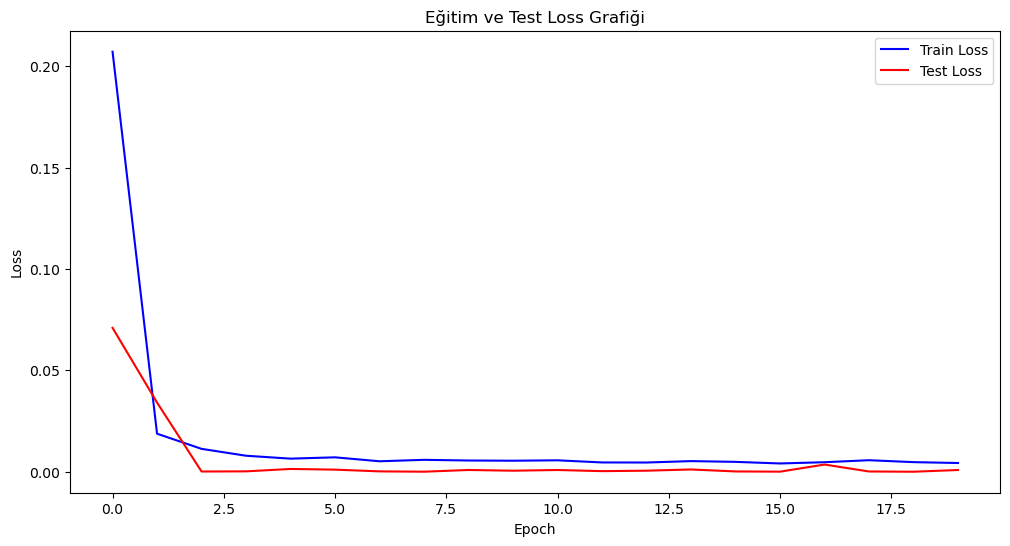

In [21]:
train_loss = history.history['loss']       # Eğitim loss değerleri
test_loss = history.history['val_loss']   # Validation loss değerleri

# Loss grafiğini çizdir

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(test_loss, label='Test Loss', color='red')
plt.title("Eğitim ve Test Loss Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 20 epoch fazla görünüyor overfit için earlystopping eklenebilir

### Tahmin ve gerçek değerlerin görselleştirilmesi

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Mean Squared Error (MSE): 0.0008841726230457425


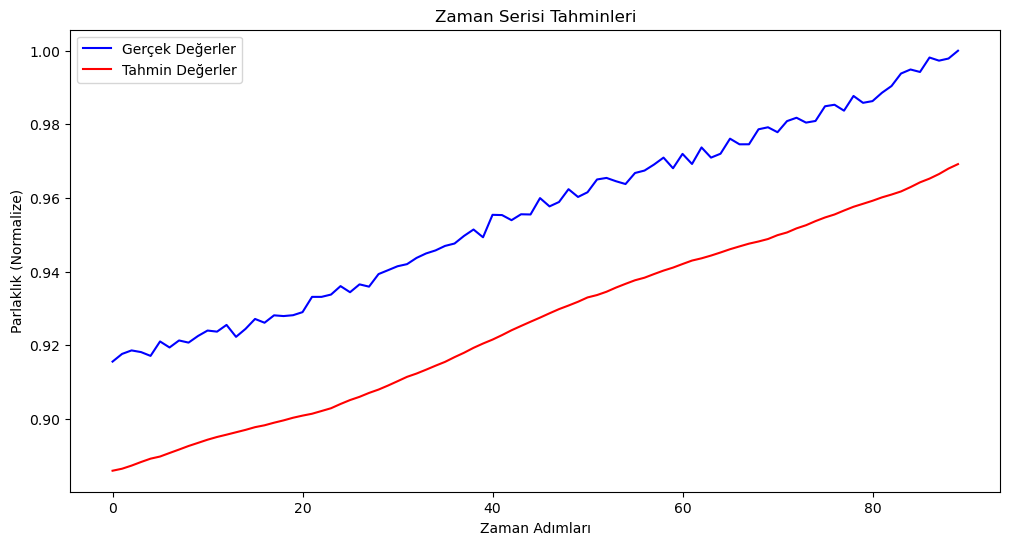

In [24]:
from sklearn.metrics import mean_squared_error

# Test seti üzerinde tahmin yap
y_pred = model.predict(X_test)

# Performans değerlendirme
mse_simple_lstm = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse_simple_lstm}")

# Tahminleri görselleştir

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Gerçek Değerler', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Tahmin Değerler', color='red')
plt.title("Zaman Serisi Tahminleri")
plt.xlabel("Zaman Adımları")
plt.ylabel("Parlaklık (Normalize)")
plt.legend()
plt.show()

### Earlystopping ekleyelim

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Test (validation) loss'u izle
    patience=4,          # 4 ardışık epoch boyunca iyileşme olmazsa durdur
    restore_best_weights=True  # En iyi ağırlıkları geri yükle
)


In [27]:
# Modeli oluştur
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Modeli derle
model.compile(optimizer='Adam', loss='mse')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Modeli eğit
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping]  # EarlyStopping'i ekledik
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3234 - val_loss: 0.3619
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0693 - val_loss: 0.0057
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 - val_loss: 0.0033
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 7.4056e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 1.0585e-05
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 8.1056e-05
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 2.1774e-04
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 9.4678e-06
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 4.0478e-05
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 6.7747e-05
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 8.2453e-04
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 9.467790732742287e-06


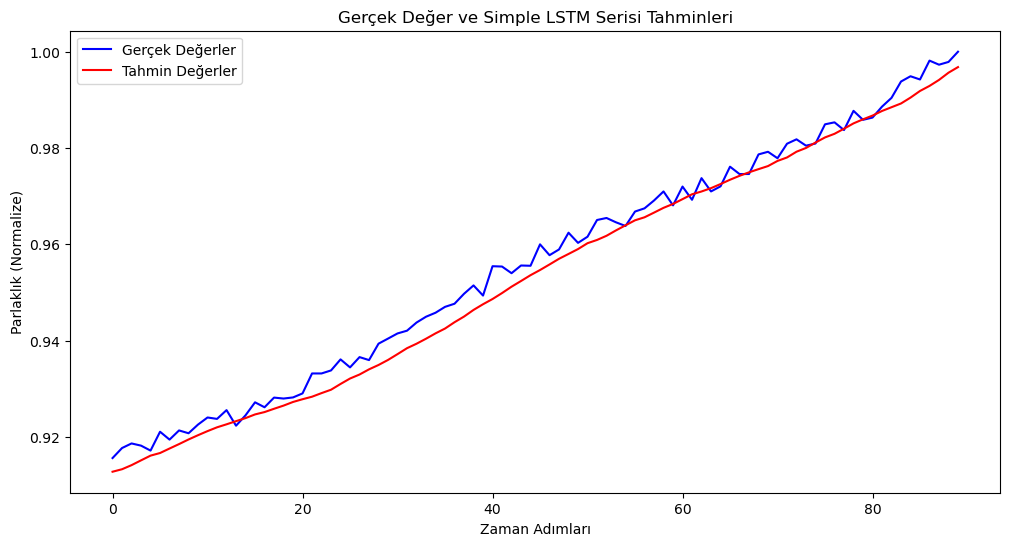

In [93]:
from sklearn.metrics import mean_squared_error

# Test seti üzerinde tahmin yap
y_pred = model.predict(X_test)

# Performans değerlendirme
mse_simple_lstm = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse_simple_lstm}")

# Tahminleri görselleştir

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Gerçek Değerler', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Tahmin Değerler', color='red')
plt.title("Gerçek Değer ve Simple LSTM Serisi Tahminleri")
plt.xlabel("Zaman Adımları")
plt.ylabel("Parlaklık (Normalize)")
plt.legend()
plt.show()

## Daha Karmaşık LSTM Modeli

In [31]:
from tensorflow.keras.layers import Bidirectional
complicated_lstm_model = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, 1))),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  
])

# Modeli derle
complicated_lstm_model.compile(optimizer='Adam', loss='mse')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:

# Modeli eğit
comp_lstm_history = complicated_lstm_model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test)
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3049 - val_loss: 0.2051
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0381 - val_loss: 3.7410e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146 - val_loss: 4.1175e-05
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - val_loss: 0.0039
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - val_loss: 0.0040
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - val_loss: 9.6719e-05
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_loss: 0.0188
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - val_loss: 0.0133
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - val_loss: 0.0145
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

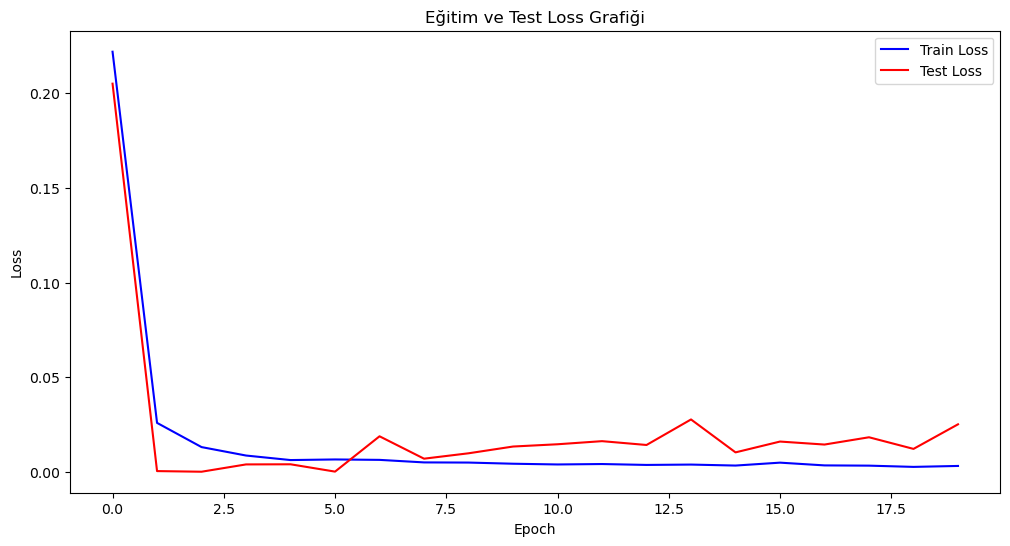

In [33]:
train_loss = comp_lstm_history.history['loss']       # Eğitim loss değerleri
test_loss = comp_lstm_history.history['val_loss']   # Validation loss değerleri

# Loss grafiğini çizdir

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(test_loss, label='Test Loss', color='red')
plt.title("Eğitim ve Test Loss Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Overfit oluşmuş gibi görünüyor, büyük ve karmaşık modeller overfite daha yatkın olabilir

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x2b1653560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Mean Squared Error (MSE): 0.025087110698223114


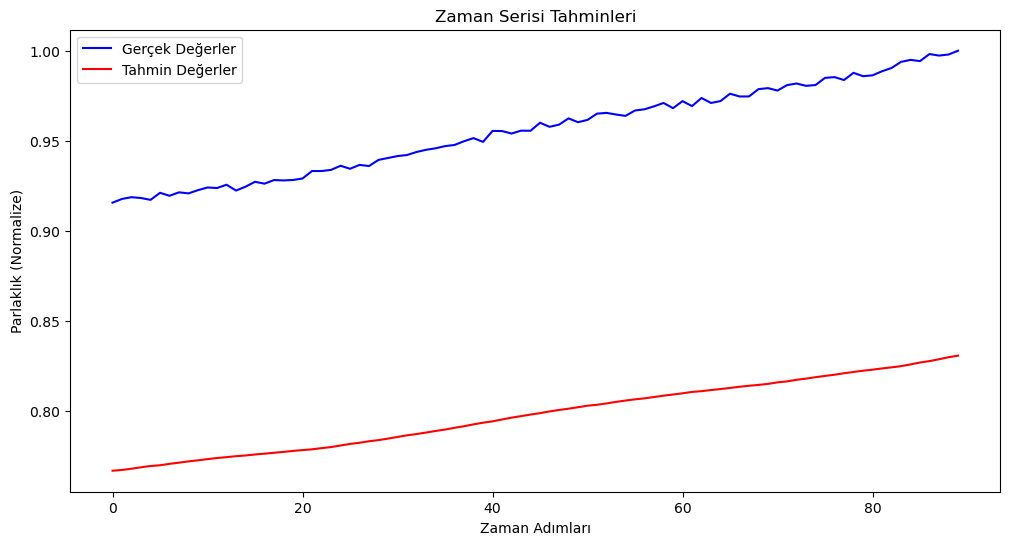

In [35]:

# Test seti üzerinde tahmin yap
y_pred = complicated_lstm_model.predict(X_test)

# Performans değerlendirme
mse_complicated_lstm = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse_complicated_lstm}")

# Tahminleri görselleştir

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Gerçek Değerler', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Tahmin Değerler', color='red')
plt.title("Zaman Serisi Tahminleri")
plt.xlabel("Zaman Adımları")
plt.ylabel("Parlaklık (Normalize)")
plt.legend()
plt.show()

### Earlystopping ile tekrar karmaşık lstm modelini eğitelim

In [37]:
complicated_lstm_model_earlystop = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, 1))),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  
])

# Modeli derle
complicated_lstm_model_earlystop.compile(optimizer='Adam', loss='mse')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Test (validation) loss'u izle
    patience=5,          # 5 ardışık epoch boyunca iyileşme olmazsa durdur
    restore_best_weights=True  # En iyi ağırlıkları geri yükle
)

In [39]:
# Modeli eğit
complicated_lstm_model_earlystop_history = complicated_lstm_model_earlystop.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping]
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3277 - val_loss: 0.0735
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0528 - val_loss: 0.0422
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0209 - val_loss: 0.0196
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152 - val_loss: 4.1076e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - val_loss: 0.0053
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093 - val_loss: 0.0033
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0099 - val_loss: 0.0039
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0084 - val_loss: 0.0032
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - val_loss: 0.0043


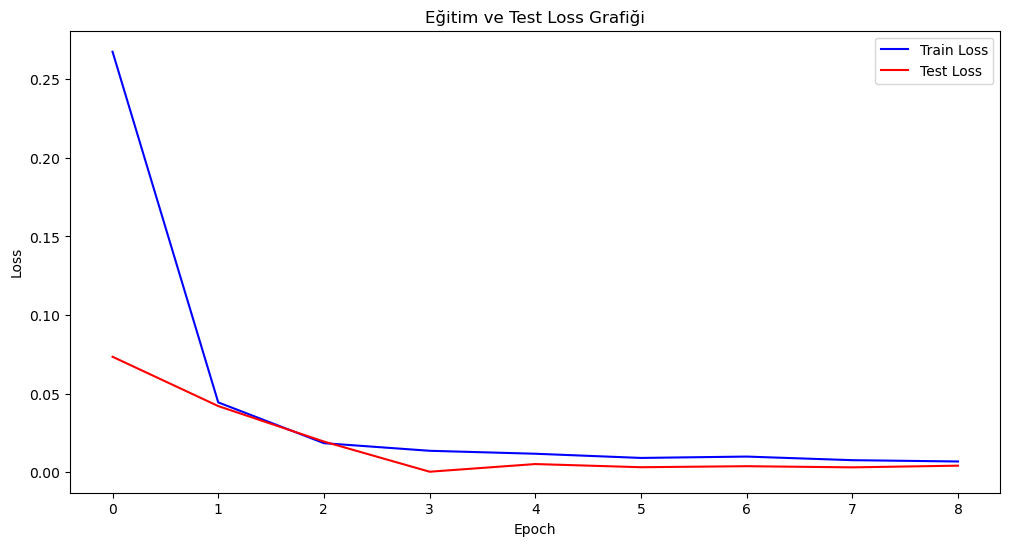

In [40]:
train_loss = complicated_lstm_model_earlystop_history.history['loss']       # Eğitim loss değerleri
test_loss = complicated_lstm_model_earlystop_history.history['val_loss']   # Validation loss değerleri

# Loss grafiğini çizdir

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(test_loss, label='Test Loss', color='red')
plt.title("Eğitim ve Test Loss Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Mean Squared Error (complicated_lstm_model): 0.0004107620916329324


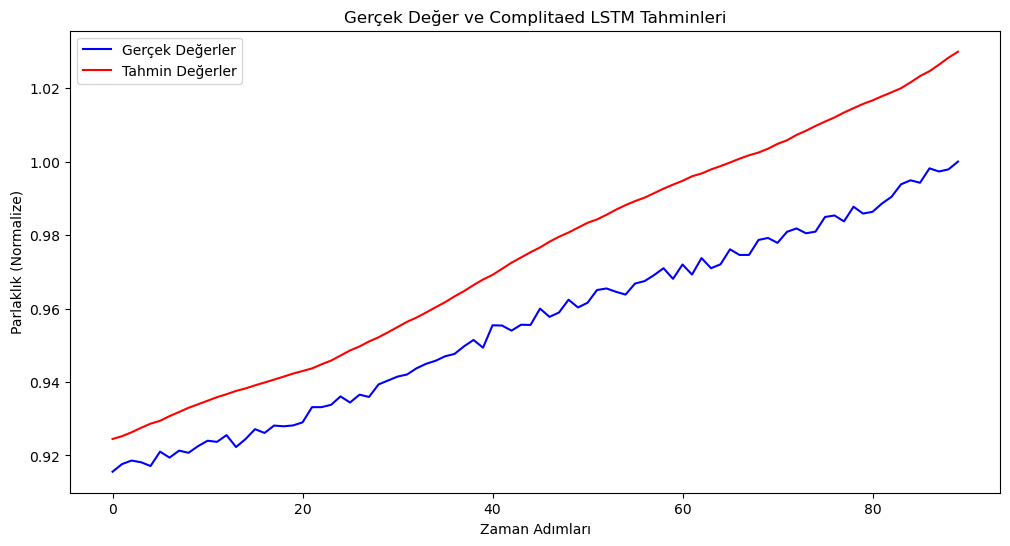

In [91]:

# Test seti üzerinde tahmin yap
y_pred = complicated_lstm_model_earlystop.predict(X_test)

# Performans değerlendirme
mse_complicated_lstm = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (complicated_lstm_model): {mse_complicated_lstm}")

# Tahminleri görselleştir

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Gerçek Değerler', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Tahmin Değerler', color='red')
plt.title("Gerçek Değer ve Complitaed LSTM Tahminleri")
plt.xlabel("Zaman Adımları")
plt.ylabel("Parlaklık (Normalize)")
plt.legend()
plt.show()

## ARIMA Model

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# ARIMA için veri hazırlığı
arima_train_data = y_train.flatten()  # ARIMA, 1D veri ister
arima_test_data = y_test.flatten()

# ARIMA modelini tanımla ve eğit
arima_model = ARIMA(arima_train_data, order=(10, 0, 1))  # (p, d, q) parametrelerini seç
arima_model_fit = arima_model.fit()



In [44]:
arima_test_forecast = arima_model_fit.forecast(steps=len(arima_test_data))

ARIMA Model Mean Squared Error (MSE): 0.001475519891616234


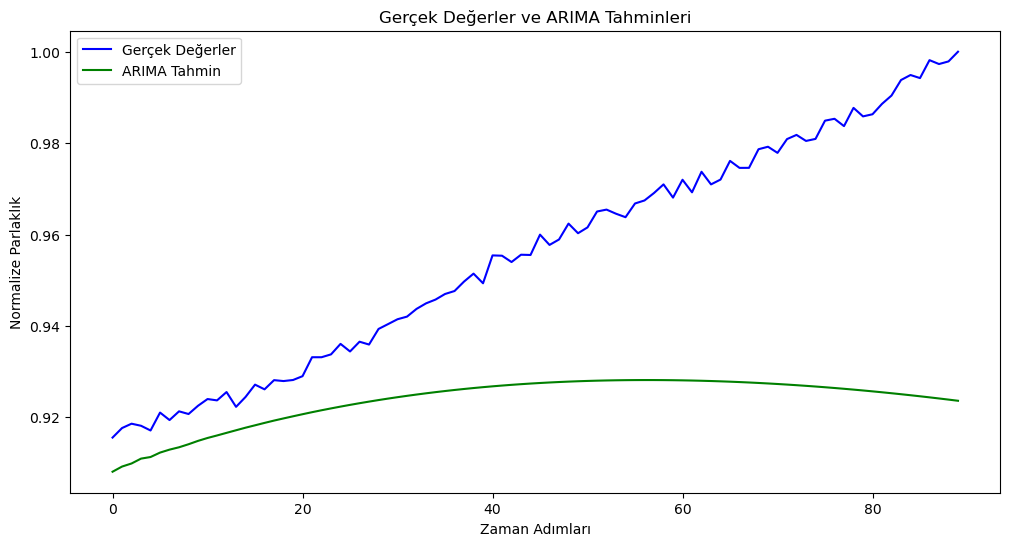

In [45]:
# Performans değerlendirme
mse_arima = mean_squared_error(arima_test_data, arima_test_forecast)
print(f"ARIMA Model Mean Squared Error (MSE): {mse_arima}")

# Gerçek değerler ve tahminlerin karşılaştırılması
plt.figure(figsize=(12, 6))
plt.plot(range(len(arima_test_data)), arima_test_data, label='Gerçek Değerler', color='blue')
plt.plot(range(len(arima_test_forecast)), arima_test_forecast, label='ARIMA Tahmin', color='green')
plt.title("Gerçek Değerler ve ARIMA Tahminleri")
plt.xlabel("Zaman Adımları")
plt.ylabel("Normalize Parlaklık")
plt.legend()
plt.show()

## SARIMA

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_train_data = y_train.flatten()
sarima_test_data = y_test.flatten()

# SARIMA modeli tanımla ve eğit
sarima_model = SARIMAX(
    sarima_train_data, 
    order=(5, 1, 0),               # ARIMA (p, d, q) parametreleri
    seasonal_order=(1, 1, 0, 12)   # SARIMA (P, D, Q, s) parametreleri (s=12 aylık döngü)
)
sarima_model_fit = sarima_model.fit()

# Test seti üzerinde tahmin yap
sarima_forecast = sarima_model_fit.forecast(steps=len(sarima_test_data))



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.75167D+00    |proj g|=  6.75808D+01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     54      2     0     0   2.422D+00  -4.757D+00
  F =  -4.7565059583148281     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Model Mean Squared Error (MSE): 0.0002475724422091179


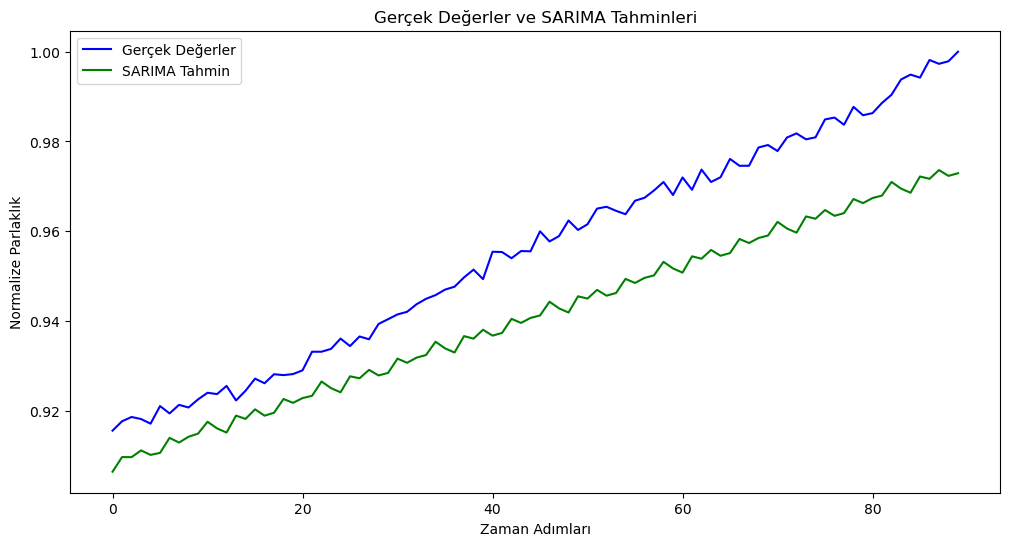

In [48]:
# Performans değerlendirme
mse_sarima = mean_squared_error(sarima_test_data, sarima_forecast)
print(f"SARIMA Model Mean Squared Error (MSE): {mse_sarima}")

#Gerçek değerler ve tahminlerin karşılaştırılması
plt.figure(figsize=(12, 6))
plt.plot(range(len(sarima_test_data)), sarima_test_data, label='Gerçek Değerler', color='blue')
plt.plot(range(len(sarima_forecast)), sarima_forecast, label='SARIMA Tahmin', color='green')
plt.title("Gerçek Değerler ve SARIMA Tahminleri")
plt.xlabel("Zaman Adımları")
plt.ylabel("Normalize Parlaklık")
plt.legend()
plt.show()

In [49]:
from pmdarima import auto_arima

# Auto ARIMA ile en iyi parametreleri bul
auto_arima_model = auto_arima(
    sarima_train_data,
    seasonal=True,
    m=12,  # Sezon uzunluğu (12 aylık döngü için)
    trace=True,
    stepwise=True
)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=-5532.884, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-4941.937, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-5243.180, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-5532.768, Time=0.31 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=-5658.220, Time=0.56 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=-5538.111, Time=0.15 sec
 ARIMA(2,2,2)(0,0,2)[12]             : AIC=-5547.514, Time=0.77 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=-5660.567, Time=0.50 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=-5547.870, Time=0.93 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=-5526.064, Time=0.88 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=-5556.768, Time=0.20 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-5657.982, Time=0.34 sec
 ARIMA(3,2,2)(1,0,0)[12]             : AIC=-5681.682, Time=0.60 sec
 ARIMA(3,2,2)(0,0,0)[12]             : AIC=-5622.088, Time=0.17 sec
 ARIM

In [50]:
# Test seti üzerinde tahmin yap
auto_arima_forecast = auto_arima_model.predict(n_periods=len(sarima_test_data))


Auto ARIMA Model Mean Squared Error (MSE): 0.00017132812207427218


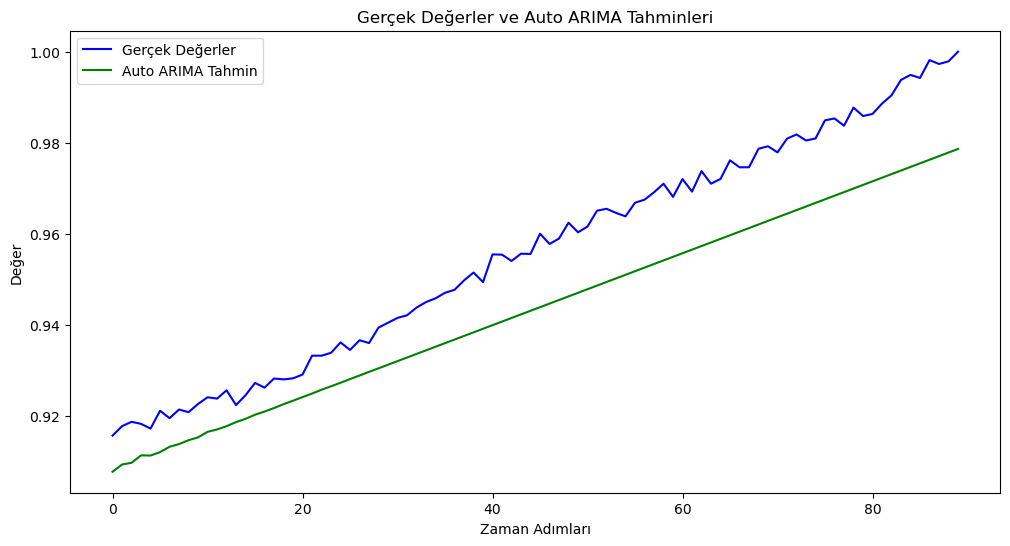

In [51]:
mse_aouto_arima = mean_squared_error(sarima_test_data, auto_arima_forecast)
print(f"Auto ARIMA Model Mean Squared Error (MSE): {mse_aouto_arima}")
# Gerçek değerler ve tahminlerin karşılaştırılması


plt.figure(figsize=(12, 6))
plt.plot(range(len(sarima_test_data)), sarima_test_data, label='Gerçek Değerler', color='blue')
plt.plot(range(len(auto_arima_forecast)), auto_arima_forecast, label='Auto ARIMA Tahmin', color='green')
plt.title("Gerçek Değerler ve Auto ARIMA Tahminleri")
plt.xlabel("Zaman Adımları")
plt.ylabel("Değer")
plt.legend()
plt.show()

In [53]:
performance_table = pd.DataFrame({
    'Model': ['LSTM', 'Complicated_LSTM', 'ARIMA','SARIMA','AUTO_ARIMA'],
    'MSE': [mse_simple_lstm, mse_complicated_lstm, mse_arima,mse_sarima,mse_aouto_arima],
})


In [54]:
performance_table = performance_table.sort_values(by='MSE', ascending=True)  # MSE'ye göre sırala
performance_table.reset_index(drop=True, inplace=True)

In [55]:
print(performance_table)

              Model       MSE
0              LSTM  0.000009
1        AUTO_ARIMA  0.000171
2            SARIMA  0.000248
3  Complicated_LSTM  0.000411
4             ARIMA  0.001476
